## Twitter Wordcloud

### Global parameters 

You will need to have set up a [Karst account](https://kb.iu.edu/d/bezu#account) first. Once you have your Karst account simply go to [rstudio.iu.edu](https://rstudio.iu.edu/auth-sign-in) and login using your IU username and passphrase.  Next, set the working directory by pointing to the location on Karst where you have stored the files. Below, we have chosen to save the folder "Text-Analysis" as a "Project" in R Studio on the Karst super-computer here at Indiana University. It contains the R scripts, texts, notebooks, and results. If you have forked and cloned the Github repository (see [textPrep.Rmd](textPrep.Rmd) for directions on how), simply point to where you have saved the folder. If you save it to your personal Karst folder, it will most likely look very similar to the example below. Karst is a unix server and so the home directory is represented by a ~ and, thus, the path will look like this "~/Text-Analysis/" (with the quotes). Alternatively, if you are on a PC, you will need to use an absolute path such as "C:/Users/XXX" (with the quotes again).

In R Studio, click Session in the menu bar > Set Working Directory > Choose Directory, then select the Text-Analysis directory in which you are working. This will set your working directory in the console pane, but make sure to copy the path into the source pane above to keep the directory constant if you close this script and reopen later. Make sure you click on the blue cube with a "R" in the center to set your working directory to your Text-Analysis project path.

HINT: Your working directory is the folder from which you will be pulling your texts.

In [1]:
setwd("~/Text-Analysis")

#### Include necessary packages for notebook 

R's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of R, others created by R users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In R Studio, packages can be installed by navigating to Tools in the menu bar > Install Packages. Or in the bottom right panel click on the "packages" tab and then click on "install."

In [3]:
library(wordcloud)
library(tm)
library(twitteR)

Here we add a line for extracting a .zip file. This step may not be needed as you can unzip files in the directory manually. However, if you are using rstudio on a server, you will need this step in order to extract the zipped file and then use it.

In [4]:
#unzip file
#zipF<- "data/twitter/neverAgain.csv.zip"
#outDir<-"data/twitter"
#unzip(zipF,exdir=outDir)

Read the .csv file (this time a curated set of tweets grabbed using the twitterR library and API authentication, then saved with the .RData extension, and converted to .csv using a different R script)

In [5]:
tweets <- read.csv("data/twitter/neverAgain.csv")

### Prepare text data

First we are going to take the list of 4000 tweets created when we grabbed the file above and convert it to utf-8 encoding, grabbing only the text column. We use 'iconv' to convert the column labeled 'text' found in our 'tweets' variable above (tweets$text) and then tell it we want to convert the text to = utf-8.

In [6]:
corpus <- iconv(tweets$text, to = "utf-8")

Let's look at the first few tweets:

In [7]:
head(corpus)

[1] "RT @canarymission: Students of Students for Justice in Palestine Mock the #Holocaust \n\n#NeverAgain #WeRemember\nhttps://t.co/cnPE7dEnik https://t.co/Xvd6IBiSPe"                                                                                                                                                                                         
[2] "RT @canarymission: Students of Students for Justice in Palestine Mock the #Holocaust \n\n#NeverAgain #WeRemember\nhttps://t.co/cnPE7dEnik https://t.co/Xvd6IBiSPe"                                                                                                                                                                                         
[3] "He duped so many #NeverAgain #MeToo https://t.co/7u4Vl5UjSR"                                                                                                                                                                                                                                                                                               
[4] "#NeverAgain #NeverForget \U0001f64f\U0001f3fc https://t.co/TuSZLe5dBb"                                                                                                                                                                                                                                                                                     
[5] "RT @MrGoalie35: #NeverAgain #NeverForget \U0001f64f\U0001f3fc https://t.co/TuSZLe5dBb"                                                                                                                                                                                                                                                                     
[6] "RT @ITB_MINCOM: #11thFebruary2018 #cameroUn #YouthDay \U0001f602\U0001f92a\U0001f921\n#SouthernCameroons says #NeverAgain\n#WeWillRESIST cameroUn’s #france-sponsored #GENOCIDE #SLAVERY #KLEPTOCRACY #ONGOING in the COUNTRY of #SouthernCameroons #Ambazonia @USEmbYaounde @BBCAfrica @bbcafrique @Reuters @UKinCameroon @dwnews https://t.co/PSSgr1N2PD"

Now we need to turn the text into a Corpus:

In [8]:
corpus <- Corpus(VectorSource(corpus))

Next, we need to eliminate any characters that are not UTF-8. If you know the encoding (in this case it usually is ASCII), then put it in the first set of quotes. If you do not, then just put another "UTF-8" so (x, "ASCII", "UTF-8", sub="") or (x, "UTF-8", "UTF-8", sub=""):

In [9]:
corpus <- tm_map(corpus,
                 content_transformer(function(x) iconv(x, "ASCII", "UTF-8", sub="")))

Now we need to convert all the text to lower case, so that "Clinton" and "clinton" are not seen as seperate words.

In [10]:
corpus <- tm_map(corpus, content_transformer(tolower))

Now we need to remove all punctuation so that only alphanumeric characters are read:

In [11]:
corpus <- tm_map(corpus, removePunctuation)

You may also wish to eliminate numbers, especially if they skew your results any, however, numbers may also be important, so that is why this one is optional:

In [12]:
corpus <- tm_map(corpus, removeNumbers)

Now we remove extra white space so what was "vote for @hillaryclinton" does not end up as "vote for  hillaryclinton" but becomes "vote for hillaryclinton."

In [13]:
corpus <- tm_map(corpus, stripWhitespace)

Now we need to remove url's so we don't end up with a lot of 'http', 'https', et cetera. We do this by creating a function that uses regular expressions to remove them and then apply that function to our "corpus."

In [14]:
removeURL <- function(x) gsub("http[[:alnum:]]*", "", x)
corpus <- tm_map(corpus, content_transformer(removeURL))

It's time to remove stopwords. In our plain text wordcloud, we used tm's options for a wordlist and will be doing the same again. Concatenated onto the list are common twitter words not yet eliminated such as "rt" (retweet), "amp" (&), the subject of our tweets "hillary", and her twitter handle (hillaryclinton) with the "@" removed.

In [15]:
corpus <- tm_map(corpus, removeWords, c(stopwords("english"),'amp','rt', 'neveragain', 'dont'))

Plot the wordcloud! There are a number of arguments you can customize: "scale"" indicates the size of the words; "max.words" controls how many words show up in the wordcloud; and we've used the library "RColorBrewer" to give us access to some predefined palettes. Note that if you change the palette, you need to tell the argument how many colors are in the new palette. 

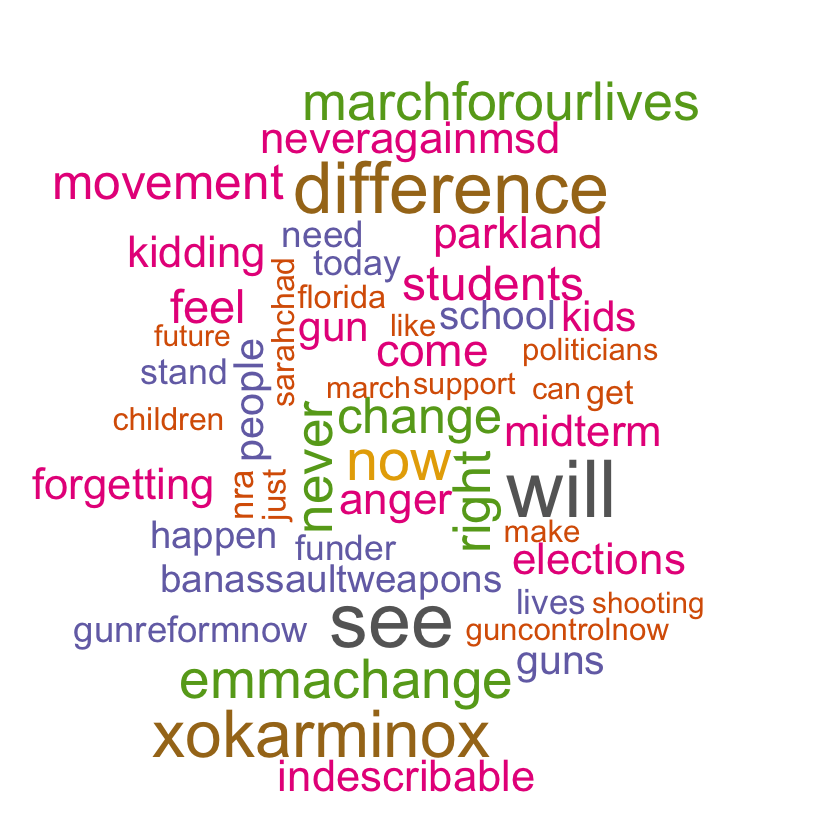

In [17]:
wordcloud(corpus, min.freq=10, max.words=50, scale=c(4,1), colors=brewer.pal(8, "Dark2"))

### VOILA!

Ackowledgements: This algorithm was adapted from the blog "Flumoxed by IT" by Hanxue Lee. This blog entry was posted March 11, 2016.
Reference: Hanxue Lee. (2016, March 11). Twitter Word Cloud Using R. Retrieved from http://flummox-engineering.blogspot.com/2016/03/twitter-word-cloud-using-r.html                           